# Introduction

This will be an explanation of a dataset of properties of cars. The goal of the exploration is to use the information to predict the fuel efficiency (in miles per gallon). The dataset is contained in the file `data/auto-mpg.data` and a description of the data is in the file `data/auto-mpg.names`.

Loading required libraries:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Some helpful functions have been written into separate python files

In [2]:
import processing as p
import regression as r

# Load the data

The data were loaded into a `pandas.DataFrame` object for ease of processing the mix of continuous and categorical data.

In [3]:
column_names = [
    'mpg', 'cylinders', 'displacement',
    'horsepower', 'weight', 'acceleration',
    'model year', 'origin', 'car name'
]
df = pd.read_csv('data/auto-mpg.data', header=None,
                 names=column_names, na_values='?',
                 sep='\s+')

In [4]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [5]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


The dataset description calls out six missing values from the horsepower column. Since these records are relatively small compared to the rest of the dataset, for now I will delete the rows.

In [6]:
df_clean = df.dropna(axis=0)

In [7]:
df_clean.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Sure enough, 6 rows of data had NA values and have now been dropped.

# Split the data for cross-validation

Physically we would not expect that any individual car's properties should depend on any other car's properties. Therefore, if we want to divide the dataset to allow for **training**, **testing**, and **valdiation** data, we can simply randomly sample from the rows. I will use 50% of the data for training, 25% for validation, and 25% for testing and reporting.

In [8]:
mask_vals = np.random.rand(len(df_clean))
train_mask = mask_vals <= 0.5
val_mask = (mask_vals > 0.5) & (mask_vals < 0.75)
test_mask = mask_vals >= 0.75

In [9]:
train = df_clean[train_mask]
val = df_clean[val_mask]
test = df_clean[test_mask]

In [10]:
print(f'train length:\t{len(train)}\n'
      f'test length:\t{len(test)}\n'
      f'val length:\t{len(val)}')

train length:	205
test length:	98
val length:	89


Just in case, save these three datasets to files for later work

In [11]:
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)
val.to_csv('data/val.csv', index=False)

# Dataset description

From the description of the dataset above (`df_clean.describe()`) we see some information fairly quickly. First, the `pandas` library is treating discrete values as continuous (luckily it was smart enough to ignore the 'car name' column).

In [12]:
continuous_columns = ['mpg', 'displacement', 'horsepower',
                      'weight', 'acceleration']

In [13]:
train_continuous = train[continuous_columns]
val_continuous = val[continuous_columns]

# Initial regression

First examine the performance of a regression using only the continuous values without rescaling the data columns.

In [14]:
r.regress(x=train[continuous_columns[1:]].values, y=train['mpg'].values)

array([-1.17270531e-02, -5.17639220e-02, -4.89699097e-03, -3.31526394e-01,
        5.11163705e+01])

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


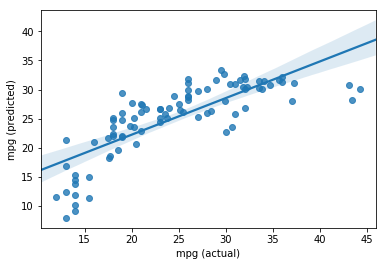

In [15]:
coefficients = r.regress(x=train[continuous_columns[1:]].values, y=train['mpg'].values)
sns.regplot(x=val['mpg'], 
                y=p.add_intercept_column(val[continuous_columns[1:]].values) \
                @ coefficients)
plt.xlabel('mpg (actual)')
plt.ylabel('mpg (predicted)')
plt.show()

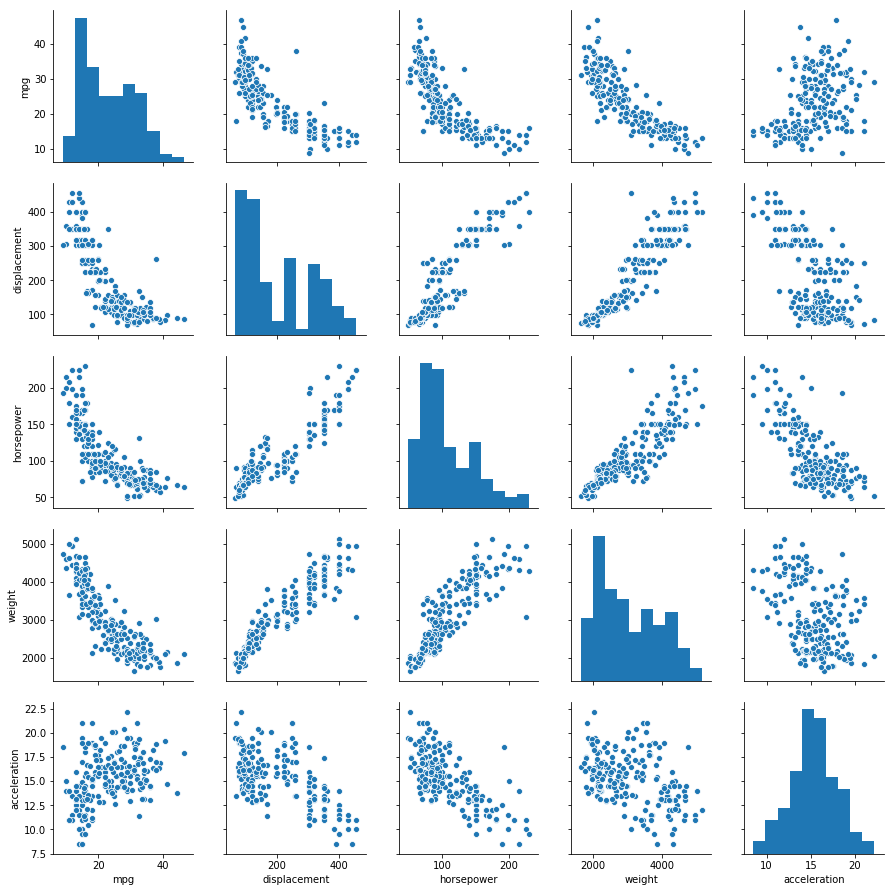

In [16]:
sns.pairplot(train_continuous)
plt.show()

This shows us that the relationship between mpg and displacement, horsepower, and weight do not appear to be linear--it looks like either a $\mathrm{e}^{-x}$ or $1/x$ relationship. To validate, let's plot mpg vs. horsepower^-1 and mpg vs log(horsepower)

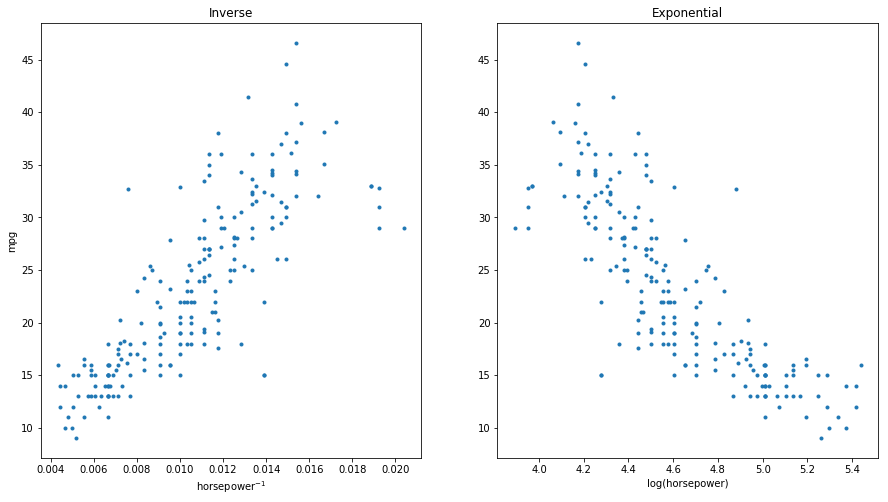

In [63]:
f = plt.figure(figsize=(15, 8))

ax1 = f.add_subplot(121)
ax1.plot(1/train['horsepower'], train['mpg'], '.')
ax1.set_title('Inverse')
ax1.set_xlabel(r'horsepower$^{-1}$')
ax1.set_ylabel('mpg')

ax2 = f.add_subplot(122, sharey=ax1)
ax2.plot(np.log(train['horsepower']), train['mpg'], '.')
ax2.set_title('Exponential')
ax2.set_xlabel('log(horsepower)')
    
plt.show()

These look more linear, but as a guess I am going to assume that the parameter to use is $1/horsepower$. Similarly, I will fit $1/displacement$ and $1/weight$

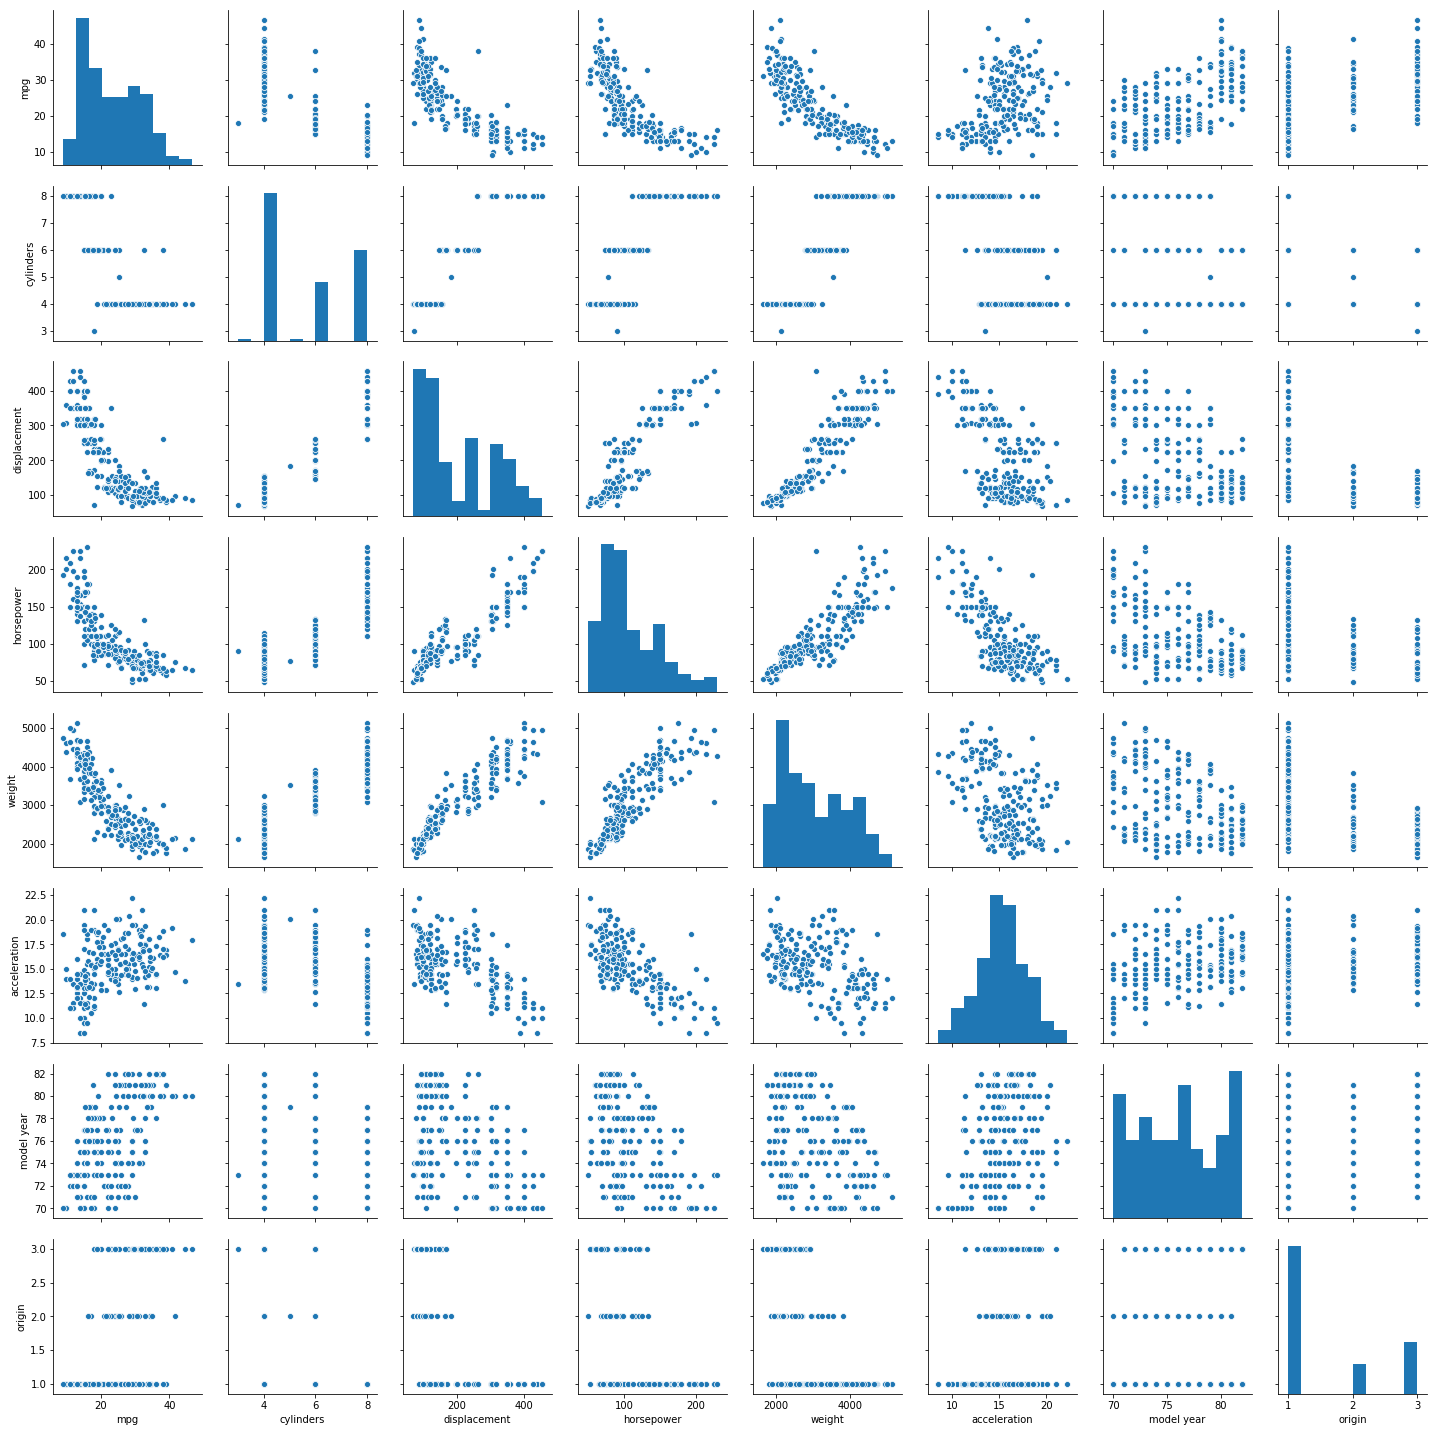

In [17]:
sns.pairplot(train)
plt.show()

There appear to be somet funny things going on in the "cylinders" column. These are typically paired, so odd numbers are unusual. Let's look at that.

In [18]:
train[train.cylinders%2!=0]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
111,18.0,3,70.0,90.0,2124.0,13.5,73,3,maxda rx3
297,25.4,5,183.0,77.0,3530.0,20.1,79,2,mercedes benz 300d


A wikipedia search for the [Mercedes 300D](https://en.wikipedia.org/wiki/Mercedes-Benz_W123) reveals that it was, in fact, offered in an inline-5 cylinder configuration.

On the other hand, the [Mazda RX-4](https://en.wikipedia.org/wiki/Mazda_Luce#Mazda_RX-4) was not offered in a 3-cylinder configuration. It's possible that this refers to the rotary Wankel engine. Cars with this engine were sold during this time period, which provides some coroborating evidence.

# TO DO: ADD MASK TO CORRELATION MATRIX

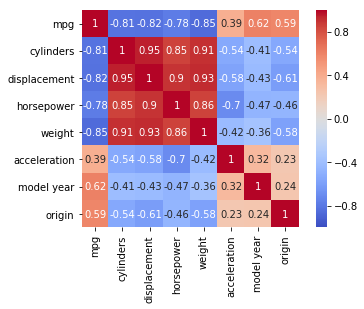

In [20]:
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm', square=True)
plt.show()

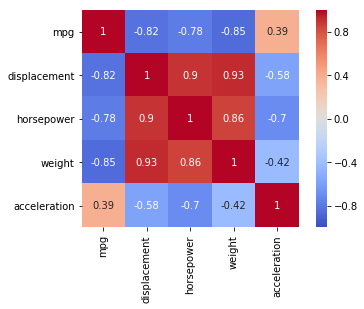

In [22]:
sns.heatmap(train_continuous.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm', square=True)
plt.show()

From this wee can see that displacement, horsepower, and weight are negatively correlated with mpg. Counterintuitively, acceleration is positively correlated with mpg.

Just for fun, let's try to figure out what the origin codes ("1", "2", and "3") correspond to

In [26]:
train[train.origin==1].head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500


In [24]:
train[train.origin==2].head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
21,24.0,4,107.0,90.0,2430.0,14.5,70,2,audi 100 ls
51,30.0,4,79.0,70.0,2074.0,19.5,71,2,peugeot 304
78,21.0,4,120.0,87.0,2979.0,19.5,72,2,peugeot 504 (sw)
79,26.0,4,96.0,69.0,2189.0,18.0,72,2,renault 12 (sw)
114,26.0,4,98.0,90.0,2265.0,15.5,73,2,fiat 124 sport coupe


In [25]:
train[train.origin==3].head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
29,27.0,4,97.0,88.0,2130.0,14.5,71,3,datsun pl510
31,25.0,4,113.0,95.0,2228.0,14.0,71,3,toyota corona
81,28.0,4,97.0,92.0,2288.0,17.0,72,3,datsun 510 (sw)
82,23.0,4,120.0,97.0,2506.0,14.5,72,3,toyouta corona mark ii (sw)
84,27.0,4,97.0,88.0,2100.0,16.5,72,3,toyota corolla 1600 (sw)


It appears that origin "1" is the United States, origin "2" is Europe, and origin "3" is Japan (or possibly Asia).

There are two 6-cylinder cars that appear to be outliers in mpg. Let's take a look  and validate the maximum of those.

In [70]:
train[train.cylinders==6].loc[train[train.cylinders==6]['mpg'].idxmax()]

mpg                                            38
cylinders                                       6
displacement                                  262
horsepower                                     85
weight                                       3015
acceleration                                   17
model year                                     82
origin                                          1
car name        oldsmobile cutlass ciera (diesel)
Name: 387, dtype: object

In fact, let's look at boxplots to examine the categorical attributes and determine 

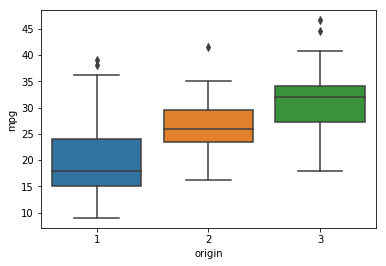

In [29]:
sns.boxplot(x='origin', y='mpg', data=train)
plt.show()

Here we can see that Japan has the highest gas mileage, America the lowest, and Europe somewhere in between.

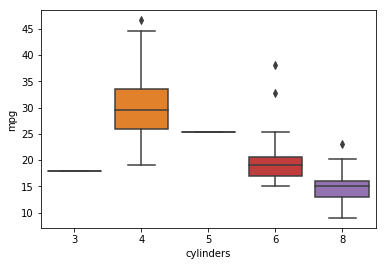

In [31]:
sns.boxplot(x='cylinders', y='mpg', data=train)
plt.show()

This shows the inverse trend of cylinder numbers to mpg. It also suggests that the 3- and 5-cylinder cars may not be representative of this overall trend and arguably should be thrown out.

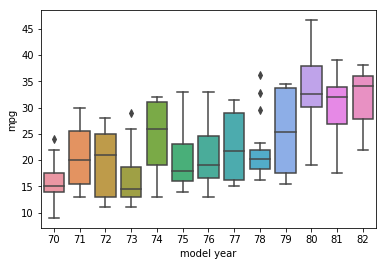

In [102]:
sns.boxplot(x='model year', y='mpg', data=train)
plt.show()

# TO DO: FIGURE OUT WHAT THE WHISKERS ARE IN BOX-AND-WHISKERS PLOT IN SEABORN

It looks like 1978 has some high mpg examples--several sigma above the mean. Let's look more closely at those.

In [45]:
train[train['model year'] == 78].sort_values('mpg')

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
277,16.2,6,163.0,133.0,3410.0,15.8,78,2,peugeot 604sl
275,17.0,6,163.0,125.0,3140.0,13.6,78,2,volvo 264gl
261,18.1,6,258.0,120.0,3410.0,15.1,78,1,amc concord d/l
264,18.1,8,302.0,139.0,3205.0,11.2,78,1,ford futura
260,18.6,6,225.0,110.0,3620.0,18.7,78,1,dodge aspen
257,19.4,6,232.0,90.0,3210.0,17.2,78,1,amc concord
249,19.9,8,260.0,110.0,3365.0,15.5,78,1,oldsmobile cutlass salon brougham
251,20.2,8,302.0,139.0,3570.0,12.8,78,1,mercury monarch ghia
254,20.2,6,200.0,85.0,2965.0,15.8,78,1,ford fairmont (auto)
253,20.5,6,200.0,95.0,3155.0,18.2,78,1,chevrolet malibu


In [38]:
train[train['model year'] == 78].describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000
mean,22.020000,5.866667,197.333333,102.466667,3009.666667,15.880000,78.0,1.400000
std,5.951614,1.407463,70.864727,26.890961,584.115530,2.235173,0.0,0.736788
min,16.200000,4.000000,78.000000,52.000000,1800.000000,11.200000,78.0,1.000000
25%,18.350000,5.000000,159.500000,87.500000,2855.000000,14.750000,78.0,1.000000
50%,20.200000,6.000000,200.000000,105.000000,3205.000000,15.800000,78.0,1.000000
75%,21.850000,6.000000,245.000000,122.500000,3410.000000,17.200000,78.0,1.500000
max,36.100000,8.000000,302.000000,139.000000,3620.000000,19.400000,78.0,3.000000


Did the Ford Fiesta *really* get 36.1 mpg? While it is the lightest car of the year, this is also worth checking out and potentially rejecting.

# TO DO: See if Pandas has a one-hot encoder

# TO DO: THROW OUT REJECTED/OUTLIERS

We should check to see how many American cars there are vice the other two origins. If the dataset is weighted it may be necessary to use a more advanced sampling procedure.

In [41]:
len(train[train['origin'] == 1])

132

In [42]:
len(train[train['origin'] == 2])

27

In [43]:
len(train[train['origin'] == 3])

46

Sure enough, this is unbalanced. Going to have to correct for this or the model will be biased

# TO DO: READ UP ON REPRESENTATIVE SAMPLING

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


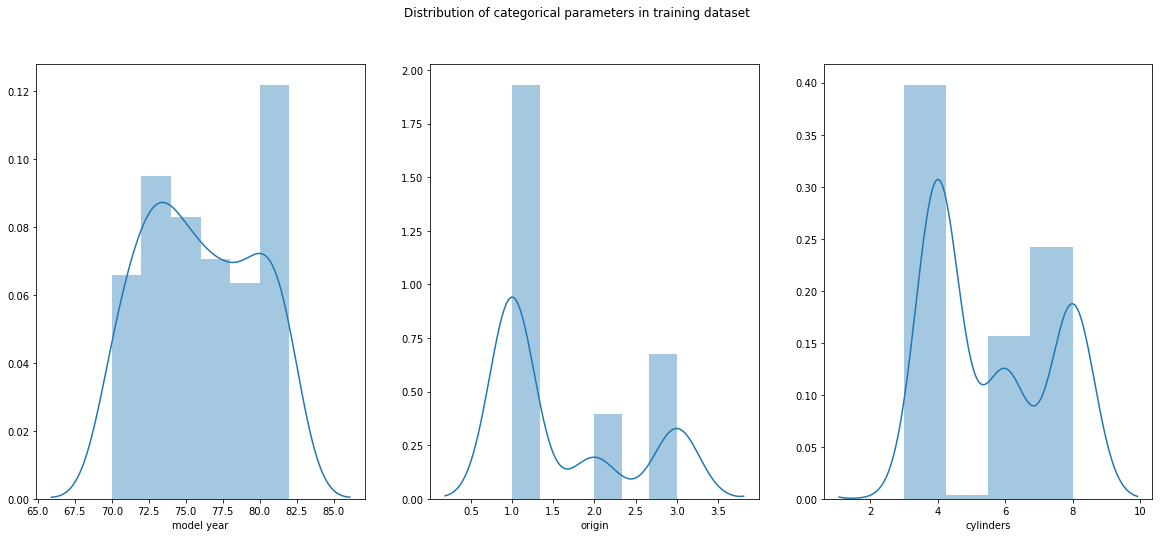

In [86]:
f = plt.figure(figsize=(20, 8))

f.add_subplot(131)
sns.distplot(train['model year'])

f.add_subplot(132)
sns.distplot(train['origin'])

f.add_subplot(133)
sns.distplot(train['cylinders'])

f.suptitle('Distribution of categorical parameters in training dataset')

plt.show()

# TO DO: FIGURE OUT HOW TO CENTER BARS IN DISTPLOT